# Part 2 (A7) - B: Census Analysis

[Mapping Reseource](http://eriqande.github.io/rep-res-web/lectures/making-maps-with-R.html)

In [1]:
library(tidyverse) # general tidyverse functions
library(censusapi) # get census data
library(maps) # mapping library
library(zipcode)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘censusapi’

The following object is masked from ‘package:methods’:

    getFunction


Attaching package: ‘maps’

The following object is masked from ‘package:purrr’:

    map



In [2]:
# sets plot height to 3.5 inches
options(repr.plot.height=3.5)

In [3]:
# my census key
Sys.setenv(CENSUS_KEY="5b1c623bfbc1a58903da4032b852e66f1b8395e9")

In [4]:
# function to export plots
make.plot = function(name, plot_expr, type="pdf", width, height, ...) {
    dir.create("data/wholefoods/images", recursive = TRUE, showWarnings = FALSE)
    if (identical(type, "pdf")) {
        pdf(sprintf("data/wholefoods/images/%s.pdf", name),
            width=width, height=height, ...)
    } else if (identical(type, "png")) {
        png(sprintf("data/wholefoods/images/%s.png", name),
            width=width, height=height, units="in", res=300, ...)
    } else {
        stop("invalid plot type")
    }
    print(plot_expr)
    dev.off()
    plot_expr
}

In [5]:
# read data file, convert columns to relevant data types

# filtered on region 7 (pacific northwest)
wfm = read_tsv('data/wholefoods/wfm_final.tsv', col_types="cccccccDddddcccc")

# updated category classifications
cats = read_csv('data/wholefoods/categories.csv', col_types="cccccc")

#Store 10564 appears to be a 'test' store of some sort.
wfm = wfm %>%
    filter(CustNum != 10564)

spec(wfm)
spec(cats)

# get zip code data
data(zipcode)

cols(
  Region = col_character(),
  CustNum = col_character(),
  Store = col_character(),
  Address = col_character(),
  City = col_character(),
  StateAbr = col_character(),
  zip = col_character(),
  Date = col_date(format = ""),
  Sales = col_double(),
  SalesLy = col_double(),
  Units = col_double(),
  UnitsLy = col_double(),
  Brand = col_character(),
  Category = col_character(),
  UPC = col_character(),
  Description = col_character()
)

cols(
  Family_01 = col_character(),
  Category_02 = col_character(),
  Subcategory_03 = col_character(),
  Class_04 = col_character(),
  UPC = col_character(),
  Product = col_character()
)

In [6]:
head(wfm)

Region,CustNum,Store,Address,City,StateAbr,zip,Date,Sales,SalesLy,Units,UnitsLy,Brand,Category,UPC,Description
Mid-West,10303,Town and Country,1160 Town and Country Crossin,Town and Country,MO,63017,2016-01-04,0.00,19.96,0,4,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz)
Mid-West,10120,West Bloomfield,7350 Orchard Lake Roa,West Bloomfield,MI,48322,2016-01-04,4.99,0.00,1,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz)
Mid-West,10460,West Des Moines,4100 University Ave Suite #26,West Des Moines,IA,50266,2016-01-04,4.99,0.00,1,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz)
Mid-West,10572,West Loop,1 N. Halsted Stree,Chicago,IL,60661,2016-01-04,4.99,0.00,1,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz)
Mid-West,10068,Wheaton,89 Danada Square Eas,Wheaton,IL,60189,2016-01-04,9.98,0.00,2,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz)
Mid-West,10573,Willowbrook,6300 S. Robert Kingery Highwa,Willowbrook,IL,60527,2016-01-04,4.99,0.00,1,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz)


In [7]:
head(cats)

Family_01,Category_02,Subcategory_03,Class_04,UPC,Product
Grocery Bulk,Baking,Flours,Almond: 48247,1037,ALMOND FLOUR EX FINE
Grocery Frozen,Vegetables,Vegetables,Vegetables: 42648,1162,BULK FROZEN FRUIT AND VEGETABLES
Grocery Bulk,Baking,Flours,Almond: 48247,1173,FLOUR ALMOND MEAL
Grocery Bulk,Cereals Hot,Cereals Hot Archive,Cereals Hot Archive: 48382,1315,CEREAL HOT HIGH FIBER OG
Coffee,Coffee,Bulk Coffee,Bulk Coffee: 45676,1341,TEA YERBA MATE
Grocery Bulk,Functional Snacks,Dried Fruits,Cranberries: 48413,1371,CRANBERRIES SUGAR SWEETENED OG


## 3. Data Summary:

In [8]:
summary(wfm)

    Region            CustNum             Store             Address         
 Length:24366132    Length:24366132    Length:24366132    Length:24366132   
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     City             StateAbr             zip                 Date           
 Length:24366132    Length:24366132    Length:24366132    Min.   :2016-01-04  
 Class :character   Class :character   Class :character   1st Qu.:2016-04-04  
 Mode  :character   Mode  :character   Mode  :character   Median :2016-07-04  
                                                          Mean   :2016-07-02  
                                                          3rd Qu.:

Join products with conosolidated category table

In [9]:
wfm_cats = wfm %>%
    left_join(cats)

Joining, by = "UPC"


Filter out products that wren't in consolidated category table

In [10]:
wfm_cats = wfm_cats %>%
    filter(Category_02 != "NA")
#tail(wfm_cats)

## 2. Compare store location to income levels from census data to evaluate a products sales effectiveness

Summarize sales by zip code

In [11]:
wfm_zip = wfm_cats %>%
    group_by(zip) %>%
    summarize(Sales=sum(Sales))
#head(wfm_zip)

Collect census data on occupancy demographics

In [12]:
state_data2010 = getCensus(name="sf1", vintage=2010,
    vars=c("NAME", "P0010001", "H0110001", "H0110002", "H0110003", "H0110004"),
                           region="state:*")
state_data2010 = select(state_data2010, state, NAME_State=NAME, Population_State=P0010001,
                        Total.Occupied.2010=H0110001, Own.Mortgage.2010=H0110002, 
                        Own.2010=H0110003, Rent.2010=H0110004)
head(state_data2010)

state,NAME_State,Population_State,Total.Occupied.2010,Own.Mortgage.2010,Own.2010,Rent.2010
01,Alabama,4779736,4663920,2300855,1010449,1352616
02,Alaska,710231,683879,326501,121937,235441
04,Arizona,6392017,6252633,3210865,923252,2118516
05,Arkansas,2915918,2836987,1314090,615128,907769
06,California,37253956,36434140,17379138,3363791,15691211
08,Colorado,5029196,4913318,2753542,569484,1590292


Occupancy data for just California, by zip code

In [13]:
zip_data2010_CA = getCensus(name="sf1", vintage=2010,
    vars=c("NAME", "P0010001", "H0110001", "H0110002", "H0110003", "H0110004", "ZCTA5"),
                         region="zip code tabulation area:*", regionin="state:06")
zip_data2010_CA = select(zip_data2010_CA, state, NAME_Zip=NAME, Population_Zip=P0010001,
                      Total.Occupied.2010=H0110001, Own.Mortgage.2010=H0110002, 
                      Own.2010=H0110003, Rent.2010=H0110004,
                      zip=zip.code.tabulation.area)
zip_data2010_CA = zip_data2010_CA %>%
    mutate(renters = 100*Rent.2010/Total.Occupied.2010)
head(zip_data2010_CA)

state,NAME_Zip,Population_Zip,Total.Occupied.2010,Own.Mortgage.2010,Own.2010,Rent.2010,zip,renters
06,ZCTA5 89010 (part),31,31,0,20,11,89010,35.48387
06,ZCTA5 89019 (part),69,69,32,13,24,89019,34.78261
06,ZCTA5 89060 (part),30,30,17,2,11,89060,36.66667
06,ZCTA5 89061 (part),51,51,25,13,13,89061,25.49020
06,ZCTA5 89439 (part),80,80,50,20,10,89439,12.50000
06,ZCTA5 90001,57110,57057,18516,2993,35548,90001,62.30261


Calculate occupancy rate of renters for a given zip code

In [14]:
County_Pop_Ratio = state_data2010 %>%
    inner_join(zip_data2010_CA, "state")

County_Pop_Ratio = select(County_Pop_Ratio, NAME_State, zip, Population_Zip, Population_State, renters)
County_Pop_Ratio = County_Pop_Ratio %>%
    mutate(Pop_Ratio = 100*(Population_Zip/Population_State))
head(County_Pop_Ratio)

Pop_Sum = County_Pop_Ratio %>%
    group_by(NAME_State) %>%
    summarize(total = sum(Pop_Ratio))
#Pop_Sum

NAME_State,zip,Population_Zip,Population_State,renters,Pop_Ratio
California,89010,31,37253956,35.48387,8.321264e-05
California,89019,69,37253956,34.78261,1.852152e-04
California,89060,30,37253956,36.66667,8.052836e-05
California,89061,51,37253956,25.49020,1.368982e-04
California,89439,80,37253956,12.50000,2.147423e-04
California,90001,57110,37253956,62.30261,1.532992e-01


Join census data with sales data by zip code 

In [15]:
wfm_census = wfm_cats %>%
    inner_join(County_Pop_Ratio)
# head(wfm_census)

Joining, by = "zip"


summarize sales by zip

In [16]:
salesandzip = wfm_census %>%
    group_by(zip, Pop_Ratio, renters) %>%
    summarize(sales = sum(Sales)) %>%
    arrange(renters)
head(salesandzip)

zip,Pop_Ratio,renters,sales
92823,0.009698299,10.04705,687564.1
94022,0.049659156,15.11622,2662286.4
94549,0.072110463,19.36051,1977075.8
94598,0.069302707,19.60876,190872.3
91326,0.090481666,20.20983,1033823.5
90210,0.058358903,21.09621,1809805.5


Plot points (zip codes) of renters vs sales to give visual representation of general occupancy type for locations 0f Whole Foods stores in Florida

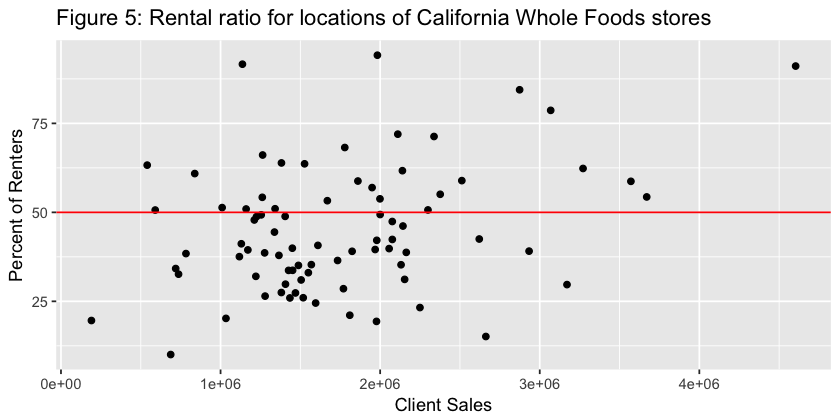

In [22]:
pointplot = ggplot(salesandzip, aes(sales, renters)) +
    geom_point() +
    geom_hline(yintercept = 50, color="red") +
    labs(title="Figure 5: Rental ratio for locations of California Whole Foods stores", y="Percent of Renters", x="Client Sales")
make.plot("rental_rate_CA",pointplot)

The data suggests whole foods typically is located in a zip code where families live in owner occupied housing, as opposed to renting.  This also suggests it would be most beneficial to target areas with high ratio of home owners for develoing our e-commerce and direct marketing channels. 

# Map Data

In [18]:
states = map_data("state")
head(states)
tail(states)

long,lat,group,order,region,subregion
-87.46201,30.38968,1,1,alabama,NA
-87.48493,30.37249,1,2,alabama,NA
-87.52503,30.37249,1,3,alabama,NA
-87.53076,30.33239,1,4,alabama,NA
-87.57087,30.32665,1,5,alabama,NA
-87.58806,30.32665,1,6,alabama,NA


,long,lat,group,order,region,subregion
15594,-106.3295,41.00659,63,15594,wyoming,NA
15595,-106.8566,41.01232,63,15595,wyoming,NA
15596,-107.3093,41.01805,63,15596,wyoming,NA
15597,-107.9223,41.01805,63,15597,wyoming,NA
15598,-109.0568,40.98940,63,15598,wyoming,NA
15599,-109.0511,40.99513,63,15599,wyoming,NA


In [19]:
wfm_map = wfm_zip %>%
    inner_join(zipcode) %>%
    filter(state != "AK") %>%
    filter(state != "HI")
head(wfm_map)

Joining, by = "zip"


zip,Sales,city,state,latitude,longitude
02138,6133.55,Cambridge,MA,42.37915,-71.12803
07624,190224.01,Closter,NJ,40.97196,-73.96166
07960,553802.21,Morristown,NJ,40.79215,-74.48559
10001,2147900.85,New York,NY,40.75074,-73.99653
10002,2165026.65,New York,NY,40.71704,-73.98700
10003,2713413.39,New York,NY,40.73251,-73.98935


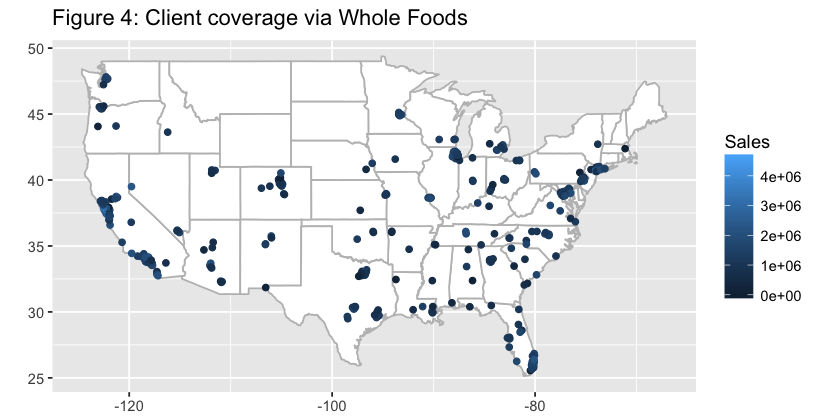

In [21]:
coverage = ggplot(wfm_map, aes(longitude,latitude)) +
    geom_polygon(data=states,aes(x=long,y=lat,group=group),color="grey",fill="white") +
    geom_point(aes(color = Sales)) +
    coord_fixed(1.3) +
    labs(title="Figure 4: Client coverage via Whole Foods", y=NULL, x=NULL)
make.plot("coverage",coverage)